## TUTORIAL 03 - Geometrical parametrization
**_Keywords: geometrical parametrization_**

### 1. Introduction

This Tutorial introduces problems featuring a geometrical parametrization, by solving a thermal conduction problem on a parametrized computational domain $\Omega_o(\boldsymbol{\mu})$.

The problem is characterized by three parameters. The parameters $\mu_0$ and $\mu_1$ are related to the shape of the central hole and vary in the following intervals
$$
\mu_0\in[0.5,1.5] \quad \text{and}\quad \mu_1\in[0.5,1.5].
$$

The parameter $\mu_2$ is the Biot number, which allows to parametrize heat exchange with a surrounding exterior fluid (e.g., air) in the following interval
$$
\mu_2\in[0.01,1];
$$
the diffusion process on the external boundaries $\Gamma_{o, 5} \cup \Gamma_{o, 6} \cup \Gamma_{o, 7} \cup \Gamma_{o, 8}$ will be affected by this parameter.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \mu_1, \mu_2)
$$
on the parameter domain
$$
\mathbb{P}=[0.5,1.5]^2\times[0.01,1].
$$

In order to obtain a faster approximation of the problem, and avoiding _any_ remeshing, we pursue a model reduction by means of a POD-Galerkin reduced order method from a fixed reference domain.

### 2. Parametrized formulation

Let $u_o(\boldsymbol{\mu})$ be the temperature in the domain $\Omega_o(\boldsymbol{\mu})$.

We will directly provide a weak formulation for this problem for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u_o(\boldsymbol{\mu})\in\mathbb{V}_o(\boldsymbol{\mu})$ such that

$$a_o\left(u_o(\boldsymbol{\mu}),v_o;\boldsymbol{\mu}\right)=f_o(v_o;\boldsymbol{\mu})\quad \forall v_o\in\mathbb{V}_o(\boldsymbol{\mu})$$

where

* the function space $\mathbb{V}_o(\boldsymbol{\mu})$ is defined as
$$
\mathbb{V}_o(\boldsymbol{\mu}) = H^1(\Omega(\boldsymbol{\mu})).
$$
Note that, in contrast to the previous tutorials, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \times \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$a_o(u_o,v_o;\boldsymbol{\mu}) = \int_{\Omega_o(\boldsymbol{\mu})}\nabla u_o\cdot\nabla v_o \ d\boldsymbol{x} + \mu_2\left(\int_{\Gamma_{o,5}}u_o\,v_o \ ds + \int_{\Gamma_{o,6}}u_o\,v_o \ ds + \int_{\Gamma_{o,7}}u_o\,v_o \ ds + \int_{\Gamma_{o,8}}u_o\,v_o \ ds\right),$$
* the parametrized linear form $f_o(\cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$f_o(v_o;\boldsymbol{\mu}) = \int_{\Gamma_{o,1}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,2}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,3}(\boldsymbol{\mu})}v_o \ ds + \int_{\Gamma_{o,4}(\boldsymbol{\mu})}v_o \ ds.$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

In order to obtain an affine decomposition, we need to recast the problem on a fixed, parameter _independent_, reference domain, as follows:

1. Choose $\Omega = \Omega_o((\mu_0, \mu_1) \equiv (1, 1))$ as reference domain, which we generate through the generate_mesh notebook provided in the _data_ folder.
2. Define a map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu}): \Omega \to \Omega_o(\boldsymbol{\mu})$ to carry out a pull back of the problem from the parametrized domain $\Omega_o(\boldsymbol{\mu})$ to the reference one $\Omega$. Since we aim at obtaining an affine decomposition, the map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu})$ should be affine in its first argument. This is possible by taking a partition of the reference domain in several triangular subdomains.
3. Define a reference function space $$\mathbb{V} = H^1(\Omega),$$ to which the pulled back solution
$$u(\boldsymbol{\cdot}; \boldsymbol{\mu}) = u_o(\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu}); \boldsymbol{\mu})$$ belongs
4. Pull back the bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu})$ and linear form $f_o(\cdot; \boldsymbol{\mu})$ onto the reference domain $\Omega$ by change of variables. Note that, due to the definition of the map $\boldsymbol{T}(\boldsymbol{\cdot}; \boldsymbol{\mu})$, the pull back will be different from one subdomain to the other. Call
$$a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$$
$$f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$$
the resulting forms (and note that their arguments are now defined on $\Omega$).
5. Solve the equivalent problem: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$


In [2]:
@PullBackFormsToReferenceDomain()
@AffineShapeParametrization("data/hole_vertices_mapping.vmp")
class Hole(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        self.subdomains = subdomains
        self.boundaries = boundaries

    # Return custom problem name
    def name(self):
        return "Hole"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.0
            theta_a1 = mu[2]
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0, )
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        u = self.u
        v = self.v
        dx = self.dx
        ds = self.ds
        if term == "a":
            a0 = inner(grad(u), grad(v)) * dx
            a1 = inner(u, v) * ds(5) + inner(u, v) * ds(6) + inner(u, v) * ds(7) + inner(u, v) * ds(8)
            return (a0, a1)
        elif term == "f":
            f0 = v * ds(1) + v * ds(2) + v * ds(3) + v * ds(4)
            return (f0, )
        elif term == "inner_product":
            x0 = u * v * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/hole.xml")
subdomains = MeshFunction("size_t", mesh, "data/hole_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/hole_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Hole class

In [5]:
problem = Hole(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.5, 1.5), (0.5, 1.5), (0.01, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-6)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2,$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the pull back of $a_o$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the pull back of $f_o$.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 17.470276471356108 	Loss(validation) = 15.508118056489284
100 0.6761023243789492 	Loss(validation) = 0.8664765864246075
200 0.5865965427341796 	Loss(validation) = 0.7966126671429413
300 0.5308971911547731 	Loss(validation) = 0.7378658955964037
400 0.47199761097552406 	Loss(validation) = 0.6704749589668408
500 0.4038536582680294 	Loss(validation) = 0.5884973386477901
600 0.34109383457202946 	Loss(validation) = 0.5136505271708531
700 0.30005448038020466 	Loss(validation) = 0.46783449323433474
800 0.27212892890001317 	Loss(validation) = 0.4357997617117523
900 0.2506936027765681 	Loss(validation) = 0.40906043859134733
1000 0.23357314107483576 	Loss(validation) = 0.38581495795876675
1100 0.21927637266449995 	Loss(validation) = 0.3644599978906656
1200 0.20636103794457808 	Loss(validation) = 0.34228446269195745
1300 0.19350772084761156 	Loss(validation) = 0.31605

In [25]:
for i in problem.boundaries.array():
    print(i)

7
0
0
6
0
4
0
3
0
0
0
0
7
8
0
2
0
0
3
0
8
0
0
5
0
1
0
0
4
0
5
0
0
0
6
0
0
0
0
1
2
0
8
8
0
0
0
0
0
0
0
0
7
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
5
0
0
6
6
0
0
0
0
0
0
0
0
8
8
0
0
0
8
8
0
4
0
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
7
0
7
0
7
7
0
0
3
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
0
5
0
5
5
0
0
6
0
6
6
6
0
0
0
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
8
8
0
0
4
4
0
0
0
0
0
0
0
0
7
7
0
0
3
0
3
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
5
5
0
0
6
6
0
0
2
2
0
6
6
0
0
0
8
8
0
0
7
7
0
0
5
5
0
0
0
0
0
0
0
4
4
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0
0
0
0
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
6
0
0
8
8
0
0
7
7
0
0
5
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
6
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
8
0
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
6
0
5
0
0
5
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
0
0
0
0
2
0
0
0
0
0
3
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [ ]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [ ]:
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [ ]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [ ]:
prnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [16]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

=                   Hole POD-Galerkin error analysis begins                    =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 99 ######################################

N 	gmean(error_u)      	max(error_u)       	gmean(relative_error_u)	max(relative_error_u)
1 	2.2784285995779836  	38.951389769180444 	0.3433598637090088     	0.7198194019894713   
2 	0.6407971717218295  	2.7367301435643743 	0.09656832326818544    	0.25286196429579416  
3 	0.37288784611276216 	1.873428642490015  	0.05619430867561037    	0.2156666249966439   
4 	0.12900590612219218 	0.5840061005765524 	0.01944122820086512    	0.07403820982528908  
5 	0.10221623832313252 	0.5624842444847615 	0.015404017341591952   	0.04654227375271154  
6 	0.07394471910133639 	0.4001510241435615 	0.011143491034715116   	0.04089347782651028  
7 	0.050119122848117564	0.20912929278585324	0.007552966633903822   	0.034163972696357195 
8 	0.03265659003506125 	0.1538540946646077 	0.00492135777514226    	0.02532526254944538  
9 	0.02460781566984959 	0.10427198867101196	0.0037084050982071474  	0.025200949983202915 
10	0.0186200844789

#### 4.6.2 PINN Error Analysis

In [17]:
test_mu = torch.tensor(reduction_method.testing_set)

In [18]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 12 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0018593154578709456	0.001648672369760283	0.00015459064014274987
mean	0.030632052156329123	0.03024320570232458	0.0020644793671949382
max	0.47354472480989773	0.4735062369755111	0.011748885175817979


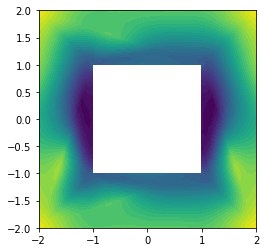

In [19]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (0.5, 0.5, 0.01), input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (0.5, 0.5, 0.01), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (0.5, 0.5, 0.01), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()